<a href="https://colab.research.google.com/github/aurelienne/convlstm/blob/main/ConvLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent neural networks for rainfall nowcasting based on weather radar data

Aurelienne Aparecida Souza Jorge

In [ ]:
%env PYTHONHASHSEED=1234

env: PYTHONHASHSEED=1234


In [ ]:
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import median_filter
from io import StringIO
import scipy
import pandas as pd
import random as python_random

In [ ]:
seed=1234
np.random.seed(seed)
python_random.seed(seed)
keras.utils.set_random_seed(seed)

# 1.Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#num_frames = 10
num_frames = 15

In [ ]:
data_list = []
for i in range(1, 36):
  #data_list.append(np.load('/content/drive/MyDrive/Doutorado/Pesquisa/dados/radar_'+str(i)+'.npy')[:, 40:120, 60:140])
  data_list.append(np.load('/content/drive/MyDrive/Doutorado/Pesquisa/dados/radar_'+str(i)+'.npy')[:, 30:130, 40:140])

## 1.1.Pre-processing

Reshaping with defined number of frames:

In [ ]:
train_ts = []
for l in range(7):
  data_array = data_list[l]
  for i in range(num_frames, data_array.shape[0], num_frames):
      train_ts.append(data_array[i-num_frames:i, :, :])

train_ts = np.array(train_ts)
data_frames = np.reshape(train_ts, (train_ts.shape[0], train_ts.shape[1], train_ts.shape[2], train_ts.shape[3], 1))
print(data_frames.shape)

(188, 15, 90, 100, 1)


Normalizing the dataset:

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
norm_data = scaler.fit_transform(data_frames.reshape(-1, data_frames.shape[-1])).reshape(data_frames.shape)
norm_data.shape

(188, 15, 90, 100, 1)

Spliting into training and test set:

In [ ]:
train_data, test_data = train_test_split(norm_data, test_size=0.2, shuffle=False)

Shifting samples in order to get x and y values (y values are always 1 step ahead of x values):

In [ ]:
x_train = train_data[:,0:num_frames-1,...]
y_train = train_data[:,1:num_frames,...]
x_test = test_data[:,0:num_frames-1,...]
y_test = test_data[:,1:num_frames,...]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(150, 14, 90, 100, 1) (38, 14, 90, 100, 1)
(150, 14, 90, 100, 1) (38, 14, 90, 100, 1)


# 2.LSTM Model

In [ ]:
epochs = 40
batch_size = 5

Reshaping data (flattening) to input to the LSTM network.

In [ ]:
x_train2 = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2]*x_train.shape[3])
y_train2 = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2]*y_train.shape[3])
x_test2 = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2]*x_test.shape[3])
y_test2 = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2]*y_test.shape[3])

test_data2 = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2]*test_data.shape[3])
test_data2.shape

(38, 15, 9000)

## 2.1.Topology

In [ ]:
def create_lstm_model(topology):
  inp = keras.layers.Input(shape=(None, x_train.shape[2]*x_train.shape[3]))

  layers = []
  x = inp
  for filters in topology:
      x = keras.layers.LSTM(
        filters,
        return_sequences=True,
        activation="relu"
      )(x)      
      #x = keras.layers.BatchNormalization()(x)
      
  x = keras.layers.Dense(
      x_train.shape[2]*x_train.shape[3], activation="relu"
  )(x)

  # Next, we will build the complete model and compile it.
  model = keras.models.Model(inp, x)

  return model

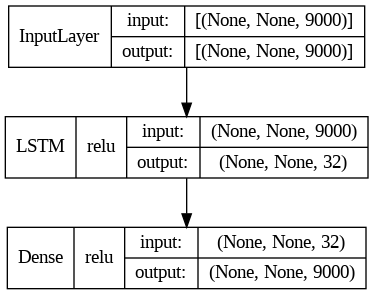

In [ ]:
model_lstm = create_lstm_model([32])
keras.utils.plot_model(model_lstm, show_shapes=True, show_layer_names=False, show_layer_activations=True)

## 2.2.Training

In [ ]:
model_lstm.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

In [ ]:
reduce_lr2 = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history_lstm = model_lstm.fit(
    x_train2,
    y_train2,
    batch_size=batch_size,
    epochs=40,
    validation_split=0.15,
    callbacks=[reduce_lr2]
)

Epoch 1/40
26/26 [==============================] - 7s 33ms/step - loss: 0.0179 - val_loss: 0.0183 - lr: 0.0010
Epoch 2/40
26/26 [==============================] - 1s 22ms/step - loss: 0.0131 - val_loss: 0.0137 - lr: 0.0010
Epoch 3/40
26/26 [==============================] - 1s 21ms/step - loss: 0.0115 - val_loss: 0.0127 - lr: 0.0010
Epoch 4/40
26/26 [==============================] - 1s 22ms/step - loss: 0.0108 - val_loss: 0.0113 - lr: 0.0010
Epoch 5/40
26/26 [==============================] - 1s 23ms/step - loss: 0.0101 - val_loss: 0.0107 - lr: 0.0010
Epoch 6/40
26/26 [==============================] - 1s 23ms/step - loss: 0.0096 - val_loss: 0.0110 - lr: 0.0010
Epoch 7/40
26/26 [==============================] - 1s 24ms/step - loss: 0.0093 - val_loss: 0.0101 - lr: 0.0010
Epoch 8/40
26/26 [==============================] - 1s 25ms/step - loss: 0.0090 - val_loss: 0.0103 - lr: 0.0010
Epoch 9/40
26/26 [==============================] - 1s 25ms/step - loss: 0.0090 - val_loss: 0.0098 - lr:

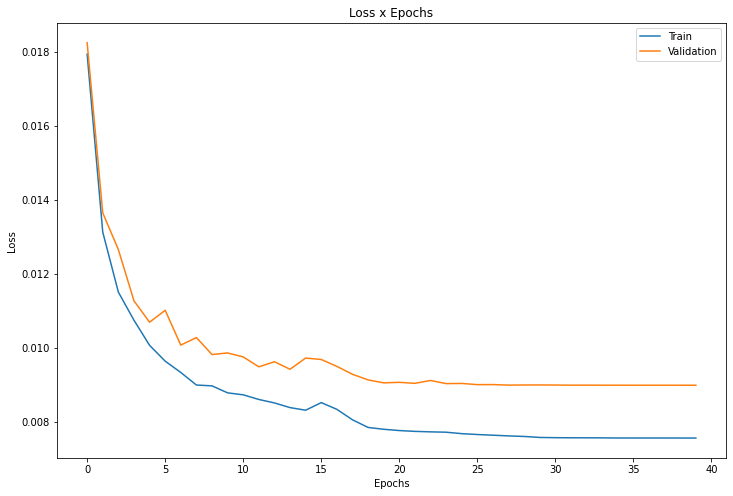

In [ ]:
def plot_loss(history):
  fig=plt.figure(figsize=(12,8))
  plt.title("Loss x Epochs")
  plt.plot(history.history['loss'], label="Train")
  plt.plot(history.history['val_loss'], label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

plot_loss(history_lstm)

## 2.3.Results

In [ ]:
result = model_lstm.evaluate(x_test2, y_test2)
result

2/2 [==============================] - 0s 9ms/step - loss: 0.0070


0.006959408521652222

In [ ]:
nobs1 = 5
nobs2 = 8
nobs3 = 10

In [ ]:
def calculate_errors_lstm(df):
  n_fcst=4

  row = df.shape[0]
  for i in range(test_data2.shape[0]):
    pred_4 = predict_lstm(test_data2[i], nobs1, 4)[4:]
    pred_5 = predict_lstm(test_data2[i], nobs2, 4)[5:]
    pred_6 = predict_lstm(test_data2[i], nobs3, 4)[6:]

    for t in range(n_fcst):
      obs_4 = test_data2[i, nobs1+t]
      obs_5 = test_data2[i, nobs2+t]
      obs_6 = test_data2[i, nobs3+t]

      df.loc[row] = [i, 'LSTM', nobs1, t+1, mean_squared_error(np.squeeze(obs_4), np.squeeze(pred_4[t]), squared=False), np.std(pred_4[t]), np.sum(pred_4[t])]
      df.loc[row+1] = [i, 'LSTM', nobs2, t+1, mean_squared_error(np.squeeze(obs_5), np.squeeze(pred_5[t]), squared=False), np.std(pred_5[t]), np.sum(pred_5[t])]
      df.loc[row+2] = [i, 'LSTM', nobs3, t+1, mean_squared_error(np.squeeze(obs_6), np.squeeze(pred_6[t]), squared=False), np.std(pred_6[t]), np.sum(pred_6[t])]
      row = row + 3
  
  #pvalues = []
  #for t in range(n_fcst):
  #  stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_4[t+1], mse_persist_4[t+1], use_continuity=True, alternative='less')
  #  pvalues.append(pvalue)
  #  stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_5[t+1], mse_persist_5[t+1], use_continuity=True, alternative='less')
  #  pvalues.append(pvalue)
  #  stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_6[t+1], mse_persist_6[t+1], use_continuity=True, alternative='less')
  #  pvalues.append(pvalue)
  #  print(pvalues)
  
  return df

# 3.ConvLSTM Model

In [ ]:
epochs = 25
batch_size = 5

## 3.1.Topology

Defining the model topology:

In [ ]:
def create_model(topology):
  inp = keras.layers.Input(shape=(None, *x_train.shape[2:]))

  layers = []
  idx = 0
  for branch_filters in topology['filters']:
    branch_kernels = topology['kernels'][idx]
    x = inp
    idx2 = 0
    for filters in branch_filters:
      kernels = branch_kernels[idx2]
      x = keras.layers.ConvLSTM2D(
        filters=filters,
        kernel_size=(kernels, kernels),
        padding="same",
        return_sequences=True,
        activation="relu"
      )(x)      
      x = keras.layers.BatchNormalization()(x)
      #if idx2 == 0:
      #  block_output = keras.layers.add([inp, x])
      #elif idx2 > 0:
      #  block_output = keras.layers.add([block_output, x])
      #x = block_output

      idx2 = idx2 + 1
    x = keras.layers.add([inp, x])
    layers.append(x)
    idx = idx + 1

  concatted = keras.layers.Concatenate()(layers)
  x = keras.layers.Conv3D(
      #filters=1, kernel_size=(1, 1, 1), strides=1, activation="sigmoid", padding="same", name="Conv3D"
      filters=1, kernel_size=(1, 1, 1), strides=1, activation="relu", padding="same", name="Conv3D"
  )(concatted)

  # Next, we will build the complete model and compile it.
  model = keras.models.Model(inp, x)

  return model

In [ ]:
models = []
#models.append({'filters': [[50], [50, 50, 50]], 'kernels': [[1], [7, 5, 3]]})
#models.append({'filters': [[100], [50, 50, 50]], 'kernels': [[1], [7, 5, 3]]})
#models.append({'filters': [[50, 50], [50, 50, 50]], 'kernels': [[1, 1], [7, 5, 3]]})
#models.append({'filters': [[50, 50, 50], [50, 50, 50]], 'kernels': [[1, 1, 1], [7, 5, 3]]})
#models.append({'filters': [[50], [50], [50]], 'kernels': [[1], [5], [3]]})
#models.append({'filters': [[50], [50], [50], [50]], 'kernels': [[1], [3], [5], [7]]})
#models.append({'filters': [[50, 50], [50, 50], [50, 50]], 'kernels': [[1, 1], [5, 5], [3, 3]]})
#models.append({'filters': [[50, 50], [50, 50], [50, 50]], 'kernels': [[1, 1], [7, 5], [5, 3]]})
#models.append({'filters': [[50, 50], [50, 50, 50], [50, 50]], 'kernels': [[1, 1], [7, 5, 3], [15, 13]]})
#models.append({'filters': [[50, 50], [50, 50], [50, 50, 50]], 'kernels': [[1, 1], [7, 5], [5, 3, 1]]})
#models.append({'filters': [[50, 50, 50], [50, 50], [50, 50]], 'kernels': [[1, 1, 1], [7, 5], [5, 3]]})
#models.append({'filters': [[100], [50], [50]], 'kernels': [[1], [5], [3]]})
#models.append({'filters': [[64, 64], [64, 64]], 'kernels': [[1, 1], [3, 3]]})
#models.append({'filters': [[50, 50], [50, 50, 50, 50]], 'kernels': [[1, 1], [3, 3, 3, 3]]})
#models.append({'filters': [[50, 50], [50, 50, 50, 50]], 'kernels': [[1, 1], [3, 3, 3, 3, 3]]})
#models.append({'filters': [[50, 50], [50, 50, 50, 50], [50, 50, 50]], 'kernels': [[1, 1], [3, 3, 3, 3], [3, 3, 3]]})

## With residual connections
##models.append({'filters': [[64, 64, 64], [64, 64]], 'kernels': [[1, 1, 1], [3, 3]]})  # Loss=0.005560554563999176   # Relu = 0.007580028381198645
#models.append({'filters': [[64, 64, 64], [64, 64, 64]], 'kernels': [[1, 1, 1], [1, 3, 1]]}) # Loss=0.006093015428632498
#models.append({'filters': [[64, 64, 64], [64, 64, 64]], 'kernels': [[1, 1, 1], [3, 3, 3]]}) # Loss=0.005655011162161827
models.append({'filters': [[64, 64, 64], [64, 64, 64, 64]], 'kernels': [[1, 1, 1], [3, 3, 3, 3]]}) # Loss=0.0055638826452195644
### models.append({'filters': [[128], [64, 64, 64, 64]], 'kernels': [[1], [3, 3, 3, 3]]})  # Loss = 0.005742218345403671
#models.append({'filters': [[32, 32, 32, 32], [32, 32, 32, 32]], 'kernels': [[1, 1, 1, 1], [3, 3, 3, 3]]}) # Loss=0.006205260753631592
#models.append({'filters': [[64, 64], [64, 64]], 'kernels': [[1, 1], [3, 3]]})  # Loss=0.0055795651860535145
#models.append({'filters': [[128], [128]], 'kernels': [[1], [3]]})  # Loss=0.006412212736904621 
#models.append({'filters': [[64, 64, 64, 64], [64, 64, 64, 64]], 'kernels': [[1, 1, 1, 1], [5, 3, 3, 1]]})  #Loss = 0.008046302013099194
#models.append({'filters': [[128, 64, 32], [64, 32], [32]], 'kernels': [[1, 1, 1], [3, 3], [5]]})  # Loss = 0.006154266651719809
#models.append({'filters': [[64, 64, 64], [64, 64], [128]], 'kernels': [[1, 3, 1], [3, 3], [1]]}) #Loss  = 0.0075210509821772575

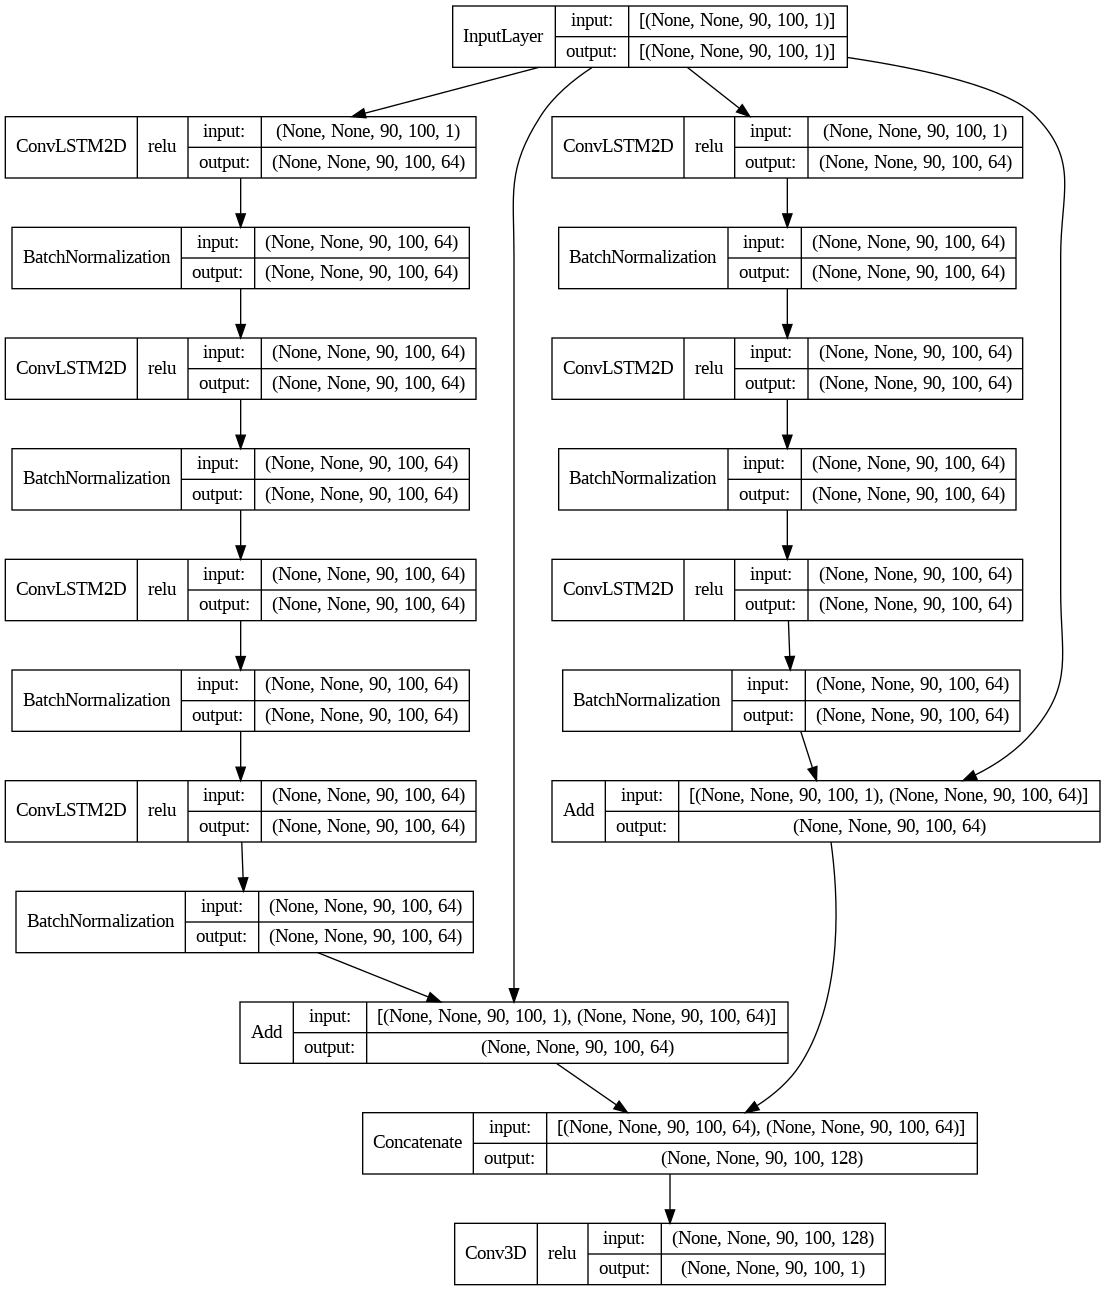

In [ ]:
model = create_model(models[0])
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

## 3.2.Training

In [ ]:
def model_fit(model):
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
  history = model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_split=0.1,
      callbacks=[reduce_lr]
  )
  return model, history

In [ ]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
model, history = model_fit(model)

Epoch 1/25


ResourceExhaustedError: ignored

In [ ]:
plot_loss(history)

## 3.3.Results

In [ ]:
result = model.evaluate(x_test, y_test)
print("Evaluation = "+str(result))

In [ ]:
def predict(sample, n_obs, n_fcst):
  frames = sample[:n_obs, ...]
  for _ in range(n_fcst):
      prediction = model.predict(np.expand_dims(frames[-n_obs:], axis=0), verbose=0)
      prediction = np.squeeze(prediction, axis=0)
      predicted_frame = np.expand_dims(prediction[-1], axis=0)
      frames = np.concatenate((frames, predicted_frame), axis=0)
  return frames

# 3.Final Results

In [ ]:
def predict_lstm(sample, n_obs, n_fcst):
  frames = sample[:n_obs, ...]
  for _ in range(n_fcst):
      prediction = model_lstm.predict(np.expand_dims(frames[-n_obs:], axis=0), verbose=0)
      prediction = np.squeeze(prediction, axis=0)
      predicted_frame = np.expand_dims(prediction[-1], axis=0)
      frames = np.concatenate((frames, predicted_frame), axis=0)
  return frames

In [ ]:
def calculate_errors():
  df = pd.DataFrame(columns=['Id_Sample', 'Model', 'n_input', 'n_fcst', 'RMSE', 'STD', 'ACC'])
  n_fcst=4

  idx_min_error = 0
  min_error = 99999
  row = 0
  for i in range(test_data.shape[0]):
    persist_4 = test_data[i, nobs1-1]
    persist_5 = test_data[i, nobs2-1]
    persist_6 = test_data[i, nobs3-1]
    pred_4 = predict(test_data[i], nobs1, 4)[4:]
    pred_5 = predict(test_data[i], nobs2, 4)[5:]
    pred_6 = predict(test_data[i], nobs3, 4)[6:]

    for t in range(n_fcst):
      obs_4 = test_data[i, nobs1+t]
      obs_5 = test_data[i, nobs2+t]
      obs_6 = test_data[i, nobs3+t]

      df.loc[row] = [i, 'Obs', nobs1, t+1, 0, np.std(obs_4), np.sum(obs_4)]
      df.loc[row+1] = [i, 'Obs', nobs2, t+1, 0, np.std(obs_5), np.sum(obs_5)]
      df.loc[row+2] = [i, 'Obs', nobs3, t+1, 0, np.std(obs_6), np.sum(obs_6)]
      df.loc[row+3] = [i, 'Persist', nobs1, t+1, mean_squared_error(np.squeeze(obs_4), np.squeeze(persist_4), squared=False), np.std(persist_4), np.sum(persist_4)]
      df.loc[row+4] = [i, 'Persist', nobs2, t+1, mean_squared_error(np.squeeze(obs_5), np.squeeze(persist_5), squared=False), np.std(persist_5), np.sum(persist_5)]
      df.loc[row+5] = [i, 'Persist', nobs3, t+1, mean_squared_error(np.squeeze(obs_6), np.squeeze(persist_6), squared=False), np.std(persist_6), np.sum(persist_6)]
      df.loc[row+6] = [i, 'ConvLSTM', nobs1, t+1, mean_squared_error(np.squeeze(obs_4), np.squeeze(pred_4[t]), squared=False), np.std(pred_4[t]), np.sum(pred_4[t])]
      df.loc[row+7] = [i, 'ConvLSTM', nobs2, t+1, mean_squared_error(np.squeeze(obs_5), np.squeeze(pred_5[t]), squared=False), np.std(pred_5[t]), np.sum(pred_5[t])]
      df.loc[row+8] = [i, 'ConvLSTM', nobs3, t+1, mean_squared_error(np.squeeze(obs_6), np.squeeze(pred_6[t]), squared=False), np.std(pred_6[t]), np.sum(pred_6[t])]
      row = row + 9
  
  #pvalues = []
  #for t in range(n_fcst):
  #  stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_4[t+1], mse_persist_4[t+1], use_continuity=True, alternative='less')
  #  pvalues.append(pvalue)
  #  stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_5[t+1], mse_persist_5[t+1], use_continuity=True, alternative='less')
  #  pvalues.append(pvalue)
  #  stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_6[t+1], mse_persist_6[t+1], use_continuity=True, alternative='less')
  #  pvalues.append(pvalue)
  #  print(pvalues)
  
  return df

In [ ]:
df_errors = calculate_errors()

In [ ]:
df_errors2 = calculate_errors_lstm(df_errors)
df_errors2

In [ ]:
def generate_coloured_image(A):
  # Get Colors
  pallete = StringIO("255	255	255	255	255	198	187	163	143	124	0	0	0	0	0	0	0	0	0	0	35	0	0	0	0	0	0	0	0	0	0	0	0	0	0	255	255	255	255	255	255	255	255	255	255	255	255	255	255	255	255	243	231	219	207	195	183	171	159	147	135	123	111	99	87	225	221	221	221	202	184	165	147	128\n"+ \
  "255	255	255	255	255	204	193	171	154	137	243	216	189	162	135	108	81	54	27	0	255	242	230	217	202	180	168	155	143	130	118	105	93	81	72	255	237	228	219	210	201	192	183	174	165	156	147	138	129	120	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	30	34	34	34	34	34	34	34	34\n"+ \
  "255	255	255	255	255	204	193	171	154	137	248	236	224	212	200	188	176	164	152	140	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	167	184	202	221	221	221	221	221	221\n"+ \
  "0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73")
  
  ac = np.loadtxt(pallete)
  col = ac[0:3].T    # Cores em RGB
  vals = ac[3].T     # Valores correspondentes

  colors = []
  values = []
  init = False
  for i in range(len(col)):
      if ((col[i, 0:3]) == 255).all() == False:
          colors.append((col[i, 0], col[i, 1], col[i, 2]))
          values.append(vals[i])

  minval = values[0]
  maxval = values[-1]

  colors = np.asarray(colors)
  ncol = len(colors)
  #position = np.linspace(0, 1, ncol)
  position = (values-(minval))/(maxval-minval)

  cdict = {'red':[], 'green':[], 'blue':[]}
  for pos, color in zip(position,colors):
      cdict['red'].append((pos,color[0]/255.,color[0]/255.))
      cdict['green'].append((pos,color[1]/255.,color[1]/255.))
      cdict['blue'].append((pos,color[2]/255.,color[2]/255.))
  my_color = LinearSegmentedColormap('custom', cdict)

  # Filtro para suavizar a imagem
  A = median_filter(A, size=3)
  A = np.ma.masked_where(np.isnan(A), A)
  A = np.ma.masked_where(A < minval, A)

  A = np.flipud(A)

  return A, my_color, minval, maxval

In [ ]:
def plot_predictions(id_sample):
  n_obs = 4
  n_fcst = 4
  sample = test_data[id_sample]
  frames = predict(sample, n_obs, n_fcst)

  obs = sample
  new_frames = frames[n_obs:, ...]

  fig=plt.figure(figsize=(12,10))
  for i in range(n_obs):
    ax = fig.add_subplot(3, n_obs, i+1)
    if i == 0:
      ax.text(-8, 60, 'Initial Steps', rotation=90, fontsize=12, fontweight='bold')
    ax.set_title('Step '+str(i+1))
    #ax.imshow(np.squeeze(frames[i]), cmap=plt.get_cmap('gray'))
    pixels, my_color, minval, maxval = generate_coloured_image(scaler.inverse_transform(np.squeeze(frames[i])))
    ax.imshow(pixels, cmap=my_color, vmin=minval, vmax=maxval)
    ax.axis("off")

  for i in range(n_fcst):
    ax = fig.add_subplot(3, n_obs, i+n_obs+1)
    if i == 0:
      ax.text(-8, 60, 'Ground Truth', rotation=90,  fontsize=12, fontweight='bold')
    ax.set_title('Step '+str(i+1))
    idx = n_obs + i
    ax.set_title('Step'+str(n_obs+i+1))
    #ax.imshow(np.squeeze(obs[n_obs+i]), cmap=plt.get_cmap('gray'))
    pixels, my_color, minval, maxval = generate_coloured_image(scaler.inverse_transform(np.squeeze(obs[n_obs+i])))
    plot = ax.imshow(pixels, cmap=my_color,  vmin=minval, vmax=maxval)
    ax.axis("off")

  mse = []
  persist = scaler.inverse_transform(np.squeeze(obs[n_obs]))
  for i in range(n_fcst):
    ax = fig.add_subplot(3, n_obs, i+n_obs+n_fcst+1)
    if i == 0:
      ax.text(-8, 50, 'Prediction', rotation=90,  fontsize=12, fontweight='bold')
    ax.set_title('Step '+str(i+1))
    ax.set_title('Step '+str(n_obs+i+1))
    #ax.imshow(np.squeeze(frames[n_obs+i]), cmap=plt.get_cmap('gray'))
    prediction = np.squeeze(frames[n_obs+i])
    pixels, my_color, minval, maxval = generate_coloured_image(scaler.inverse_transform(prediction))
    #print(minval, maxval)
    #print(np.min(pixels), np.max(pixels))
    ax.imshow(pixels, cmap=my_color, vmin=minval, vmax=maxval)
    ax.axis("off")
    mse.append(mean_squared_error(np.squeeze(obs[n_obs+i]), prediction))

  cax = plt.axes([0.95, 0.1, 0.025, 0.8])
  cbar = plt.colorbar(plot, cax=cax)
  cbar.set_label('Reflectivity (dBz)')
  plt.show()

In [ ]:
#plot_predictions(42)

In [ ]:
def plot_error_accprec_boxplots(df_errors):
  fcst = df_errors['n_fcst'].unique()
  n_fcst = np.max(fcst)
  
  mse_pred_4_1q, mse_pred_4_2q, mse_pred_4_3q, mse_pred_4_4q = [], [], [], []
  for f in range(1, n_fcst+1):
    acc4 = df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f)]['ACC']
    acc4_1q = acc4.describe().loc['25%']
    acc4_2q = acc4.describe().loc['50%']
    acc4_3q = acc4.describe().loc['75%']

    mse_pred_4_1q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC < acc4_1q)]['RMSE'])
    mse_pred_4_2q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC < acc4_2q)]['RMSE'])
    mse_pred_4_3q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC < acc4_3q)]['RMSE'])
    mse_pred_4_4q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC >= acc4_3q)]['RMSE'])

  def set_color_boxplot(bp, color, linestyle):
    plt.setp(bp['boxes'], color=color, linestyle=linestyle)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], markerfacecolor=color)

  fig=plt.figure(figsize=(15,7))
  plt.ylabel('RMSE (log)')
  plt.xlabel('Time steps ahead')
  bp_pred_1q = plt.boxplot(mse_pred_4_1q, whis=1.5, notch=True, positions=[1.2, 2.7, 4.2, 5.7], widths=0.1, showfliers=False)
  bp_pred_2q = plt.boxplot(mse_pred_4_2q, whis=1.5, notch=True, positions=[1.5, 3, 4.5, 6], widths=0.1, showfliers=False)
  bp_pred_3q = plt.boxplot(mse_pred_4_3q, whis=1.5, notch=True, positions=[1.8, 3.3, 4.8, 6.3], widths=0.1, showfliers=False)
  bp_pred_4q = plt.boxplot(mse_pred_4_4q, whis=1.5, notch=True, positions=[2.1, 3.6, 5.1, 6.6], widths=0.1, showfliers=False)
  set_color_boxplot(bp_pred_1q, 'b', linestyle='-')
  set_color_boxplot(bp_pred_2q, 'r', linestyle='-')
  set_color_boxplot(bp_pred_3q, 'g', linestyle='-')
  set_color_boxplot(bp_pred_4q, 'y', linestyle='-')
  plt.plot([], c='b', linestyle='-', label='Acc. Prec. - 1st quartile')
  plt.plot([], c='r', linestyle='-', label='Acc. Prec. - 2nd quartile')
  plt.plot([], c='g', linestyle='-', label='Acc. Prec. - 3rd quartile')
  plt.plot([], c='y', linestyle='-', label='Acc. Prec. - 4th quartile')
  plt.legend()
  plt.xticks([1.65, 3.15, 4.65, 6.15], [int(f) for f in fcst])
  plt.grid(alpha=0.5, axis='y')
  plt.yscale('log')
  plt.show()

In [ ]:
def plot_error_accprec_boxplots2(df_errors):
  fcst = df_errors['n_fcst'].unique()
  n_fcst = np.max(fcst)
  
  mse_pred_4_1q, mse_pred_4_2q, mse_pred_4_3q, mse_pred_4_4q = [], [], [], []
  mse_persist_4_1q, mse_persist_4_2q, mse_persist_4_3q, mse_persist_4_4q = [], [], [], []
  for f in range(1, n_fcst+1):
    acc4 = df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==4) & (df_errors.n_fcst==f)]['ACC']
    acc4_1q = acc4.describe().loc['25%']
    acc4_2q = acc4.describe().loc['50%']
    acc4_3q = acc4.describe().loc['75%']

    acc4_1q_samples = df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC < acc4_1q)]['Id_Sample']
    acc4_2q_samples = df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC < acc4_2q)]['Id_Sample']
    acc4_3q_samples = df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC < acc4_3q)]['Id_Sample']
    acc4_4q_samples = df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.ACC >= acc4_3q)]['Id_Sample']

    mse_pred_4_1q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_1q_samples.values))]['RMSE'])
    mse_pred_4_2q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_2q_samples.values))]['RMSE'])
    mse_pred_4_3q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_3q_samples.values))]['RMSE'])
    mse_pred_4_4q.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_4q_samples.values))]['RMSE'])
    mse_persist_4_1q.append(df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_1q_samples.values))]['RMSE'])
    mse_persist_4_2q.append(df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_2q_samples.values))]['RMSE'])
    mse_persist_4_3q.append(df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_3q_samples.values))]['RMSE'])
    mse_persist_4_4q.append(df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==4) & (df_errors.n_fcst==f) & (df_errors.Id_Sample.isin(acc4_4q_samples.values))]['RMSE'])
    
  def set_color_boxplot(bp, color, linestyle):
    plt.setp(bp['boxes'], color=color, linestyle=linestyle)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], markerfacecolor=color)

  fig=plt.figure(figsize=(15,7))
  plt.ylabel('RMSE (log)')
  plt.xlabel('Time steps ahead')
  bp_pred_1q = plt.boxplot(mse_pred_4_1q, whis=1.5, notch=True, positions=[1.2, 2.7, 4.2, 5.7], widths=0.1, showfliers=False)
  bp_pred_2q = plt.boxplot(mse_pred_4_2q, whis=1.5, notch=True, positions=[1.5, 3, 4.5, 6], widths=0.1, showfliers=False)
  bp_pred_3q = plt.boxplot(mse_pred_4_3q, whis=1.5, notch=True, positions=[1.8, 3.3, 4.8, 6.3], widths=0.1, showfliers=False)
  bp_pred_4q = plt.boxplot(mse_pred_4_4q, whis=1.5, notch=True, positions=[2.1, 3.6, 5.1, 6.6], widths=0.1, showfliers=False)
  bp_persist_1q = plt.boxplot(mse_persist_4_1q, whis=1.5, notch=True, positions=[1.35, 2.85, 4.35, 5.85], widths=0.1, showfliers=False)
  bp_persist_2q = plt.boxplot(mse_persist_4_2q, whis=1.5, notch=True, positions=[1.65, 3.15, 4.65, 6.15], widths=0.1, showfliers=False)
  bp_persist_3q = plt.boxplot(mse_persist_4_3q, whis=1.5, notch=True, positions=[1.95, 3.45, 4.95, 6.45], widths=0.1, showfliers=False)
  bp_persist_4q = plt.boxplot(mse_persist_4_4q, whis=1.5, notch=True, positions=[2.25, 3.75, 5.25, 6.75], widths=0.1, showfliers=False)
  
  set_color_boxplot(bp_pred_1q, 'b', linestyle='-')
  set_color_boxplot(bp_pred_2q, 'r', linestyle='-')
  set_color_boxplot(bp_pred_3q, 'g', linestyle='-')
  set_color_boxplot(bp_pred_4q, 'y', linestyle='-')
  set_color_boxplot(bp_persist_1q, 'b', linestyle='--')
  set_color_boxplot(bp_persist_2q, 'r', linestyle='--')
  set_color_boxplot(bp_persist_3q, 'g', linestyle='--')
  set_color_boxplot(bp_persist_4q, 'y', linestyle='--')

  plt.plot([], c='b', linestyle='-', label='ConvLSTM - Acc. Prec. - 1st quartile')
  plt.plot([], c='r', linestyle='-', label='ConvLSTM - Acc. Prec. - 2nd quartile')
  plt.plot([], c='g', linestyle='-', label='ConvLSTM - Acc. Prec. - 3rd quartile')
  plt.plot([], c='y', linestyle='-', label='ConvLSTM - Acc. Prec. - 4th quartile')
  plt.plot([], c='b', linestyle='--', label='Persistence - Acc. Prec. - 1st quartile')
  plt.plot([], c='r', linestyle='--', label='Persistence - Acc. Prec. - 2nd quartile')
  plt.plot([], c='g', linestyle='--', label='Persistence - Acc. Prec. - 3rd quartile')
  plt.plot([], c='y', linestyle='--', label='Persistence - Acc. Prec. - 4th quartile')

  plt.legend()
  plt.xticks([1.65, 3.15, 4.65, 6.15], [int(f) for f in fcst])
  plt.grid(alpha=0.5, axis='y')
  plt.yscale('log')
  plt.show()

In [ ]:
#plot_error_accprec_boxplots2(df_errors)

In [ ]:
def plot_lstm_boxplots(df_errors):
  fcst = df_errors['n_fcst'].unique()
  n_fcst = np.max(fcst)
  
  mse_pred_4, mse_pred_5, mse_pred_6 = [], [], []
  mse_persist_4, mse_persist_5, mse_persist_6 = [], [], []
  mse_lstm_4, mse_lstm_5, mse_lstm_6 = [], [], []
  std_obs_4, std_obs_6 = [], []
  
  for f in range(1, n_fcst+1):
    mse_pred_4.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==nobs1) & (df_errors.n_fcst==f)]['RMSE'])
    mse_pred_6.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==nobs3) & (df_errors.n_fcst==f)]['RMSE'])
    mse_persist_4.append(df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==nobs1) & (df_errors.n_fcst==f)]['RMSE'])
    mse_persist_6.append(df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==nobs3) & (df_errors.n_fcst==f)]['RMSE'])
    mse_lstm_4.append(df_errors[(df_errors.Model=='LSTM') & (df_errors.n_input==nobs1) & (df_errors.n_fcst==f)]['RMSE'])
    mse_lstm_6.append(df_errors[(df_errors.Model=='LSTM') & (df_errors.n_input==nobs3) & (df_errors.n_fcst==f)]['RMSE'])
    std_obs_4.append((df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==nobs1) & (df_errors.n_fcst==f)]['STD']).mean())
    std_obs_6.append((df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==nobs3) & (df_errors.n_fcst==f)]['STD']).mean())
  std_obs_avg = (np.mean(std_obs_4) + np.mean(std_obs_6))/2

  def set_color_boxplot(bp, color, linestyle):
    plt.setp(bp['boxes'], color=color, linestyle=linestyle)
    plt.setp(bp['whiskers'], color=color, linestyle=linestyle)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], markerfacecolor=color)

  fig=plt.figure(figsize=(15,7))
  plt.ylabel('RMSE (log)')
  plt.xlabel('Time steps ahead')
  plt.axhline(std_obs_avg, color='red', label="Ground Truth Standard Deviation", linestyle='--')
  bp_pred_4 = plt.boxplot(mse_pred_4, whis=1.5, notch=True, positions=[1.2, 3.2, 5.2, 7.2], widths=0.1, showfliers=False)
  bp_persist_4 = plt.boxplot(mse_persist_4, whis=1.5, notch=True, positions=[1.4, 3.4, 5.4, 7.4], widths=0.1, showfliers=False)
  bp_pred_6 = plt.boxplot(mse_pred_6, whis=1.5, notch=True, positions=[2, 4, 6, 8], widths=0.1, showfliers=False)
  bp_persist_6 = plt.boxplot(mse_persist_6, whis=1.5, notch=True, positions=[2.2, 4.2, 6.2, 8.2], widths=0.1, showfliers=False)
  bp_lstm_4 = plt.boxplot(mse_lstm_4, notch=True, positions=[1, 3, 5, 7], widths=0.1, showfliers=False)
  bp_lstm_6 = plt.boxplot(mse_lstm_6, notch=True, positions=[1.8, 3.8, 5.8, 7.8], widths=0.1, showfliers=False)
  set_color_boxplot(bp_pred_4, 'b', linestyle='-')
  set_color_boxplot(bp_pred_6, 'g', linestyle='-')
  set_color_boxplot(bp_persist_4, 'b', linestyle=':')
  set_color_boxplot(bp_persist_6, 'g', linestyle=':')
  set_color_boxplot(bp_lstm_4, 'b', linestyle='--')
  set_color_boxplot(bp_lstm_6, 'g', linestyle='--')
  plt.plot([], c='b', label='Input of '+str(nobs1)+' time steps (ConvLSTM)')
  plt.plot([], c='g', label='Input of '+str(nobs1)+' time steps (ConvLSTM)')
  plt.plot([], c='b', linestyle=':', label='Input of '+str(nobs1)+' time steps (Persistence)')
  plt.plot([], c='g', linestyle=':', label='Input of '+str(nobs3)+' time steps (Persistence)')
  plt.plot([], c='b', linestyle='--', label='Input of '+str(nobs1)+' time steps (LSTM)')
  plt.plot([], c='g', linestyle='--', label='Input of '+str(nobs3)+' time steps (LSTM)')
  plt.legend()
  plt.xticks([1.5, 3.5, 5.5, 7.5], [int(f) for f in fcst])
  plt.grid(alpha=0.5, axis='y')
  plt.yscale('log')
  plt.ylim(0.02, 0.5)  
  #plt.ylim(0.0005, 0.1)  
  plt.show()

In [ ]:
plot_lstm_boxplots(df_errors2)

In [ ]:
def mann_whitney_test():
  n_fcst = 4
  for f in range(1, n_fcst+1):
    mse_pred_4 = (df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==nobs1) & (df_errors.n_fcst==f)]['RMSE'])
    mse_pred_6 = (df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==nobs3) & (df_errors.n_fcst==f)]['RMSE'])
    mse_persist_4 = (df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==nobs1) & (df_errors.n_fcst==f)]['RMSE'])
    mse_persist_6 = (df_errors[(df_errors.Model=='Persist') & (df_errors.n_input==nobs3) & (df_errors.n_fcst==f)]['RMSE'])
    mse_lstm_4 = (df_errors[(df_errors.Model=='LSTM') & (df_errors.n_input==nobs1) & (df_errors.n_fcst==f)]['RMSE'])
    mse_lstm_6 = (df_errors[(df_errors.Model=='LSTM') & (df_errors.n_input==nobs3) & (df_errors.n_fcst==f)]['RMSE'])

    # Testes de hipotese:  
    print("Forecast="+str(f))
    stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_4.tolist(), mse_persist_4.tolist(), use_continuity=True, alternative='less')
    print("ConvLSTM < Persist - Input="+str(nobs1)+" - p-value=" + str(pvalue))
    stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_4.tolist(), mse_lstm_4.tolist(), use_continuity=True, alternative='less')
    print("ConvLSTM < LSTM - Input="+str(nobs1)+" - p-value=" + str(pvalue))
    stat, pvalue = scipy.stats.mannwhitneyu(mse_lstm_4.tolist(), mse_persist_4.tolist(), use_continuity=True, alternative='less')
    print("LSTM < Persist - Input="+str(nobs1)+" - p-value=" + str(pvalue))
    stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_6.tolist(), mse_persist_6.tolist(), use_continuity=True, alternative='less')
    print("ConvLSTM < Persist - Input="+str(nobs3)+" - p-value=" + str(pvalue))
    stat, pvalue = scipy.stats.mannwhitneyu(mse_pred_6.tolist(), mse_lstm_6.tolist(), use_continuity=True, alternative='less')
    print("ConvLSTM < LSTM - Input="+str(nobs3)+" - p-value=" + str(pvalue))
    stat, pvalue = scipy.stats.mannwhitneyu(mse_lstm_6.tolist(), mse_persist_6.tolist(), use_continuity=True, alternative='less')
    print("LSTM < Persist - Input="+str(nobs3)+" - p-value=" + str(pvalue))

mann_whitney_test()

In [ ]:
def plot_std_boxplots(df_errors):
  fcst = df_errors['n_fcst'].unique()
  n_fcst = np.max(fcst)
  
  std_obs_4, std_obs_5, std_obs_6 = [], [], []
  std_pred_4, std_pred_5, std_pred_6 = [], [], []
  for f in range(1, n_fcst+1):
    std_obs_4.append(df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==4) & (df_errors.n_fcst==f)]['STD'])
    std_obs_5.append(df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==5) & (df_errors.n_fcst==f)]['STD'])
    std_obs_6.append(df_errors[(df_errors.Model=='Obs') & (df_errors.n_input==6) & (df_errors.n_fcst==f)]['STD'])
    std_pred_4.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==4) & (df_errors.n_fcst==f)]['STD'])
    std_pred_5.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==5) & (df_errors.n_fcst==f)]['STD'])
    std_pred_6.append(df_errors[(df_errors.Model=='ConvLSTM') & (df_errors.n_input==6) & (df_errors.n_fcst==f)]['STD'])

  def set_color_boxplot(bp, color, linestyle):
    plt.setp(bp['boxes'], color=color, linestyle=linestyle)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], markerfacecolor=color)

  fig=plt.figure(figsize=(15,7))
  plt.ylabel('Standard Deviation')
  plt.xlabel('Time steps ahead')
  bp_std_4 = plt.boxplot(std_obs_4, whis=1.5, notch=True, positions=[1.15, 3.15, 5.15, 7.15], widths=0.1, showfliers=False)
  bp_pred_4 = plt.boxplot(std_pred_4, whis=1.5, notch=True, positions=[1.3, 3.3, 5.3, 7.3], widths=0.1, showfliers=False)
  #bp_std_5 = plt.boxplot(std_obs_5, whis=1.5, notch=True, positions=[1.65, 3.65, 5.65, 7.65], widths=0.1, showfliers=False)
  #bp_pred_5 = plt.boxplot(std_pred_5, whis=1.5, notch=True, positions=[1.8, 3.8, 5.8, 7.8], widths=0.1, showfliers=False)
  bp_std_6 = plt.boxplot(std_obs_6, whis=1.5, notch=True, positions=[2.15, 4.15, 6.15, 8.15], widths=0.1, showfliers=False)
  bp_pred_6 = plt.boxplot(std_pred_6, whis=1.5, notch=True, positions=[2.3, 4.3, 6.3, 8.3], widths=0.1, showfliers=False)
  set_color_boxplot(bp_std_4, 'b', linestyle='-')
  #set_color_boxplot(bp_std_5, 'r', linestyle='-')
  set_color_boxplot(bp_std_6, 'g', linestyle='-')
  set_color_boxplot(bp_pred_4, 'b', linestyle='--')
  #set_color_boxplot(bp_pred_5, 'r', linestyle='--')
  set_color_boxplot(bp_pred_6, 'g', linestyle='--')
  plt.plot([], c='b', label='Input of 4 time steps (Ground Truth)')
  #plt.plot([], c='r', label='Input of 5 time steps (Ground Truth)')
  plt.plot([], c='g', label='Input of 6 time steps (Ground Truth)')
  plt.plot([], c='b', linestyle='--', label='Input of 4 time steps (ConvLSTM)')
  #plt.plot([], c='r', linestyle='--', label='Input of 5 time steps (ConvLSTM)')
  plt.plot([], c='g', linestyle='--', label='Input of 6 time steps (ConvLSTM)')
  plt.legend()
  plt.xticks([1.5, 3.5, 5.5, 7.5], [int(f) for f in fcst])
  plt.grid(alpha=0.5, axis='y')
  plt.yscale('log')
  plt.show()

In [ ]:
#plot_std_boxplots(df_errors)